# 使用国内资产复现bender的论文 -- 使用pca因子

In [35]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm
from sklearn.decomposition import PCA

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

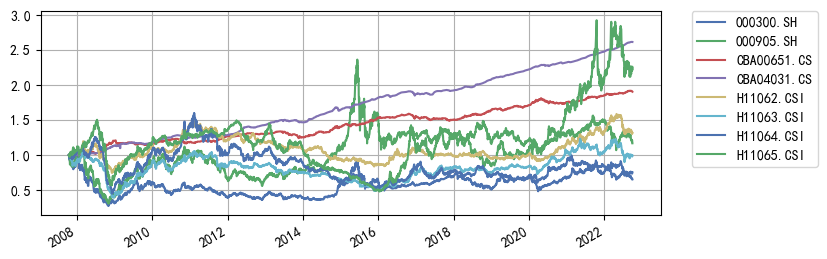

In [36]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
(asset_data_raw.dropna()/asset_data_raw.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [37]:
# 回测参数
date_range = [datetime(2014,1,1), datetime(2021,12,31)]
frequency = 22 
look_back = 252*3

## 1. 计算fmp

In [38]:
class pcaFmpStrategy(Strategy):
    def __init__(self, n_components=5, i_component=0):
        super().__init__()
        self._n_components = n_components
        self._i_component = i_component

    def getPcaFactorReturns(self, asset_data):
        asset_data = asset_data.rolling(22).mean().dropna()
        asset_return = asset_data.pct_change().fillna(0)

        pca=PCA(n_components=self._n_components)  
        asset_return_pca = pca.fit_transform(asset_return)
        asset_return_pca = pd.DataFrame(asset_return_pca)

        asset_return_pca.index = asset_data.index
        asset_return_pca.columns = ['factor_{}'.format(i) for i in range(asset_return_pca.shape[1])]

        return asset_return_pca

    def run(self, id_date, asset_data):
        pca_factor_returns = self.getPcaFactorReturns(asset_data)
        asset_returns = asset_data.pct_change().reindex(pca_factor_returns.index)
        exposure = getFatorExposureFrame(asset_returns, pca_factor_returns, norm=False).iloc[:, self._i_component]

        if exposure.sum() < 0:
            exposure *= -1


        # print(exposure)
        # sys.exit(1)
        return exposure


In [39]:
fmp_values = pd.DataFrame()
fmp_weights = {}

for i in range(5):
    column_name = 'factor_{}'.format(i)
    fmp_return_backtest = BacktestManager(
            pcaFmpStrategy(i_component=i), 
            asset_data_raw, 
            date_range = date_range, 
            frequency = frequency, 
            look_back = look_back, 
        )
    fmp_return_backtest.run()
    fmp_values[column_name] = fmp_return_backtest.getHistoricalValue(scale=True)
    fmp_weights[column_name] = pd.DataFrame(columns=asset_data_raw.columns)
    for id_date, weights in fmp_return_backtest._historcial_weights.items():
        fmp_weights[column_name].loc[id_date] = weights.reindex(fmp_weights[column_name].columns)

100%|██████████| 1950/1950 [00:11<00:00, 176.67it/s]


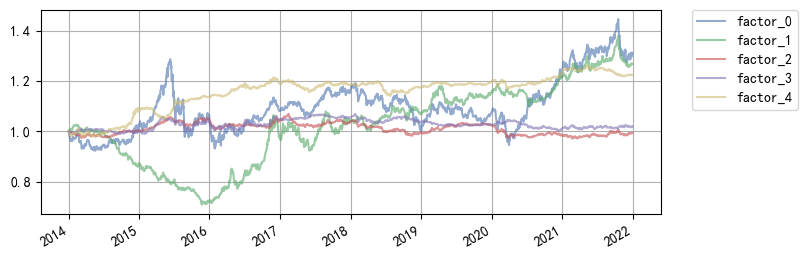

In [40]:
fmp_values.plot(figsize=(8,3), grid=True, alpha=0.6)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

## 2. 预测资产收益

In [41]:
# 使用历史收益率作为fmp收益率预测
fmp_lookback = 252 * 1
tmp_fmp_returns = fmp_values.loc[:id_date].iloc[-fmp_lookback:].pct_change().fillna(0)

In [42]:
class AssetAlphaStrategy(Strategy):
    def __init__(self, fmp_value):
        super().__init__()
        self._asset_alpha = pd.DataFrame(columns=list(asset_data_raw.columns))
        self._opt_fp_df = pd.DataFrame(columns=list(fmp_value))
        self._fmp_returns = fmp_value.pct_change()

    def run(self, id_date, asset_data):
        opt_fp = optimalFactorPortfolio(self._fmp_returns.loc[:id_date].iloc[-fmp_lookback:])
        self._opt_fp_df.loc[id_date] = list(opt_fp.values[0])
        tmp_fmp_weights = pd.DataFrame({factor: v.loc[id_date].reindex(list(asset_data.columns)) for factor,v in fmp_weights.items()})
        tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-fmp_lookback:]
        self._asset_alpha.loc[id_date] = list(getAssetExpectedReturns(opt_fp, tmp_fmp_weights, tmp_asset_returns).values[0])
        # print(list(getAssetExpectedReturns(opt_fp, tmp_fmp_weights, tmp_asset_returns).values[0]))
        # sys.exit(1)
        return pd.Series([0]*asset_data.shape[1], index=asset_data.columns)
        

In [43]:
date_range = [datetime(2015,1,30), datetime(2021,12,31)]
aa_backtest = BacktestManager(
    AssetAlphaStrategy(fmp_values), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
aa_backtest.run()

  1%|▏         | 23/1686 [00:00<00:16, 100.44it/s]

2015-01-30 00:00:00: skip
2015-03-10 00:00:00: skip


  4%|▍         | 67/1686 [00:00<00:12, 127.59it/s]

2015-04-10 00:00:00: skip
2015-05-13 00:00:00: skip


  6%|▌         | 104/1686 [00:00<00:14, 107.34it/s]

2015-06-12 00:00:00: skip


  8%|▊         | 133/1686 [00:01<00:14, 105.88it/s]

2015-07-15 00:00:00: skip
2015-08-14 00:00:00: skip


 11%|█         | 178/1686 [00:01<00:14, 105.23it/s]

2015-09-17 00:00:00: skip
2015-10-26 00:00:00: skip


 14%|█▎        | 228/1686 [00:01<00:10, 135.42it/s]

2015-11-25 00:00:00: skip
2015-12-25 00:00:00: skip


 15%|█▌        | 258/1686 [00:02<00:10, 133.47it/s]

2016-01-27 00:00:00: skip
2016-03-04 00:00:00: skip


 18%|█▊        | 309/1686 [00:02<00:09, 152.68it/s]

2016-04-06 00:00:00: skip
2016-05-09 00:00:00: skip


 21%|██        | 347/1686 [00:02<00:08, 148.86it/s]

2016-06-08 00:00:00: skip
2016-07-12 00:00:00: skip


 24%|██▎       | 397/1686 [00:03<00:08, 145.86it/s]

2016-08-11 00:00:00: skip
2016-09-12 00:00:00: skip


 27%|██▋       | 451/1686 [00:03<00:08, 148.62it/s]

2016-10-21 00:00:00: skip
2016-11-22 00:00:00: skip


 29%|██▉       | 485/1686 [00:03<00:07, 150.39it/s]

2016-12-22 00:00:00: skip
2017-01-24 00:00:00: skip


 31%|███       | 524/1686 [00:03<00:07, 160.91it/s]

2017-03-02 00:00:00: skip
2017-04-05 00:00:00: skip


 34%|███▍      | 574/1686 [00:04<00:07, 143.13it/s]

2017-05-08 00:00:00: skip
2017-06-09 00:00:00: skip


 37%|███▋      | 617/1686 [00:04<00:09, 116.52it/s]

2017-07-11 00:00:00: skip
2017-08-10 00:00:00: skip


 39%|███▉      | 663/1686 [00:04<00:07, 133.88it/s]

2017-09-11 00:00:00: skip
2017-10-18 00:00:00: skip


 42%|████▏     | 704/1686 [00:05<00:06, 156.12it/s]

2017-11-17 00:00:00: skip
2017-12-19 00:00:00: skip


 45%|████▍     | 753/1686 [00:05<00:06, 151.28it/s]

2018-01-19 00:00:00: skip
2018-02-27 00:00:00: skip


 48%|████▊     | 807/1686 [00:05<00:05, 165.19it/s]

2018-03-29 00:00:00: skip
2018-05-04 00:00:00: skip


 50%|████▉     | 839/1686 [00:06<00:06, 138.47it/s]

2018-06-05 00:00:00: skip
2018-07-06 00:00:00: skip


 52%|█████▏    | 879/1686 [00:06<00:04, 161.89it/s]

2018-08-07 00:00:00: skip
2018-09-06 00:00:00: skip


 55%|█████▌    | 931/1686 [00:06<00:04, 162.78it/s]

2018-10-16 00:00:00: skip
2018-11-15 00:00:00: skip


 57%|█████▋    | 967/1686 [00:06<00:04, 165.11it/s]

2018-12-17 00:00:00: skip
2019-01-18 00:00:00: skip


 60%|██████    | 1016/1686 [00:07<00:04, 145.76it/s]

2019-02-26 00:00:00: skip
2019-03-28 00:00:00: skip


 63%|██████▎   | 1063/1686 [00:07<00:04, 141.78it/s]

2019-04-30 00:00:00: skip
2019-06-04 00:00:00: skip


 65%|██████▍   | 1093/1686 [00:07<00:04, 131.96it/s]

2019-07-05 00:00:00: skip


 67%|██████▋   | 1122/1686 [00:08<00:04, 124.85it/s]

2019-08-06 00:00:00: skip
2019-09-05 00:00:00: skip


 69%|██████▉   | 1167/1686 [00:08<00:03, 130.80it/s]

2019-10-15 00:00:00: skip
2019-11-14 00:00:00: skip


 71%|███████▏  | 1204/1686 [00:08<00:03, 136.94it/s]

2019-12-16 00:00:00: skip


 73%|███████▎  | 1233/1686 [00:08<00:03, 119.22it/s]

2020-01-16 00:00:00: skip
2020-02-25 00:00:00: skip


 76%|███████▌  | 1281/1686 [00:09<00:03, 116.24it/s]

2020-03-26 00:00:00: skip
2020-04-28 00:00:00: skip


 79%|███████▊  | 1325/1686 [00:09<00:02, 125.19it/s]

2020-06-02 00:00:00: skip
2020-07-06 00:00:00: skip


 82%|████████▏ | 1381/1686 [00:10<00:02, 148.71it/s]

2020-08-05 00:00:00: skip
2020-09-04 00:00:00: skip


 84%|████████▍ | 1413/1686 [00:10<00:02, 135.26it/s]

2020-10-14 00:00:00: skip
2020-11-13 00:00:00: skip


 87%|████████▋ | 1466/1686 [00:10<00:01, 150.81it/s]

2020-12-15 00:00:00: skip
2021-01-15 00:00:00: skip


 89%|████████▉ | 1499/1686 [00:10<00:01, 155.92it/s]

2021-02-23 00:00:00: skip
2021-03-25 00:00:00: skip


 91%|█████████ | 1536/1686 [00:11<00:00, 164.00it/s]

2021-04-27 00:00:00: skip
2021-06-01 00:00:00: skip


 94%|█████████▍| 1591/1686 [00:11<00:00, 163.89it/s]

2021-07-02 00:00:00: skip
2021-08-03 00:00:00: skip


 96%|█████████▋| 1624/1686 [00:11<00:00, 155.49it/s]

2021-09-02 00:00:00: skip
2021-10-13 00:00:00: skip


100%|█████████▉| 1679/1686 [00:11<00:00, 159.15it/s]

2021-11-12 00:00:00: skip
2021-12-14 00:00:00: skip


100%|██████████| 1686/1686 [00:12<00:00, 140.36it/s]


In [44]:
# asset alpha
aa_backtest._strategy._asset_alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
2015-01-30,-0.341615,-0.299866,0.044170,0.007798,-0.177405,-0.389012,-0.616496,-0.609955
2015-03-10,0.124712,0.166348,0.032198,0.009521,-0.189193,-0.295698,-0.494537,-0.426904
2015-04-10,0.744202,0.741063,0.022456,0.010694,-0.184394,-0.243942,-0.436718,-0.451049
2015-05-13,0.794818,0.811313,0.021652,0.013152,-0.077744,-0.131730,-0.213907,-0.270312
2015-06-12,1.050510,1.190319,0.019944,0.013525,-0.136225,-0.162735,-0.257442,-0.178986
...,...,...,...,...,...,...,...,...
2021-08-03,-0.364260,-0.286082,-0.002561,0.000022,0.038807,0.073937,0.084268,0.108655
2021-09-02,-0.249649,-0.174994,-0.004546,0.000024,0.063086,0.138571,0.143904,0.208519
2021-10-13,-0.085079,0.000456,-0.011713,0.001991,0.259227,0.335385,0.455959,0.722102
2021-11-12,-0.102305,-0.062302,-0.006273,0.000202,0.126209,0.134798,0.214742,0.270965


In [45]:
aa_backtest._strategy._asset_alpha.to_csv(os.path.join(this_path, '../data/assets/asset_alpha_pca.csv'))